In [68]:
from pathlib import Path
import numpy as np
import pandas as pd
import hdbscan
import seaborn as sns


from collections import Counter
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


from sklearn.metrics import silhouette_score

In [69]:
here = Path.cwd()
root = next(p for p in [here, *here.parents] if (p / "data" / "processed").exists())
full_df = pd.read_csv(root / "data" / "processed" / "state1" / "android_df.csv", header=0)
filtered_df = full_df[full_df['eventType'] == 5].reset_index(drop=True)
geo_cols = filtered_df[["eventStartLatitude", "eventStartLongitude",
                        "eventEndLatitude", "eventEndLongitude"]].copy()
df = filtered_df.drop(columns=['is_ios', 'eventType', 'eventSampleSpeed', 'eventGPSSignalStrength', 'eventStart', 'eventEnd', 'eventStartLatitude', 'eventStartLongitude', 'eventEndLatitude',
       'eventEndLongitude'])
print(df.columns.to_list())
print(df.shape)



['eventDurationSeconds', 'eventMilesDriven', 'eventStartSpeed', 'eventEndSpeed', 'memsMedianHorizontalNorm', 'gyro_angular_change_per_second', 'gyroAngleChange', 'mems_radius']
(115, 8)


In [70]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(X_scaled, columns=df.columns)

In [71]:
def calculate_gini_score(labels):
    counts = Counter(labels)
    counts.pop(-1, None)
    values = np.array(list(counts.values()), dtype=float)
    if values.size <= 1:
        return 0.0
    numerator = np.abs(values[:, None] - values[None, :]).sum()
    base = 2 * values.size * values.sum()
    gini = numerator / base
    max_possible = (values.size - 1) / values.size  # rescales so 1.0 means "fully imbalanced"
    return float(gini / max_possible) if max_possible else 0.0


In [72]:
# k means model
results_list = []
# possible k values
for k in [2, 3, 4, 5]:
    kmeans_final = KMeans(n_clusters=k, random_state=42)
    kmeans_final.fit(scaled_df)
    final_labels = kmeans_final.labels_

    sil_score = silhouette_score(scaled_df, final_labels)
    noise_percentage = 0.0
    gini_score = calculate_gini_score(final_labels)

    results_list.append({
        'model': 'kmeans',
        'sil. #': sil_score,
        'Gini': gini_score,
        'noise %': noise_percentage,
        'clust. #': k
    })    


In [73]:
N_total = X_scaled.shape[0]

In [74]:
# DBSCAN modeling
for eps in np.linspace(0.1, 2.0, 20):
    for min_pts in [2, 40]:
        db = DBSCAN(eps=eps, min_samples=min_pts, n_jobs=-1).fit(X_scaled)
        labels = db.labels_
        
        non_noise_mask = labels != -1
        data_non_noise = X_scaled[non_noise_mask]
        labels_non_noise = labels[non_noise_mask]
        n_clusters = len(np.unique(labels_non_noise))
        n_noise = np.sum(labels == -1)
    
        if n_clusters >= 2 and len(labels_non_noise) >= 2:
            sil_score = silhouette_score(data_non_noise, labels_non_noise)
        else:
            sil_score = np.nan 
            
        noise_percentage = (n_noise / N_total) * 100
        gini_score = calculate_gini_score(labels) 

        results_list.append({
            'model': 'dbscan',
            'HP (eps)': eps, 
            'HP (min_samp)': min_pts,
            'sil. #': sil_score,
            'Gini': gini_score,
            'noise %': noise_percentage,
            'clust. #': n_clusters
        })

In [75]:
# HDBSCAN modeling
for min_samp in [2, 15]:
    for min_cluster_size in [2, 40]:
        clusterer = hdbscan.HDBSCAN(min_samples=min_samp, min_cluster_size=min_cluster_size)
        clusterer.fit(X_scaled)
        labels = clusterer.labels_
        
        non_noise_mask = labels != -1
        data_non_noise = X_scaled[non_noise_mask]
        labels_non_noise = labels[non_noise_mask]
        n_clusters = len(np.unique(labels_non_noise))
        n_noise = np.sum(labels == -1)
        noise_percentage = (n_noise / N_total) * 100

        if n_clusters >= 2 and len(labels_non_noise) >= 2 and noise_percentage < 15:
            sil_score = silhouette_score(data_non_noise, labels_non_noise)
        else:
            sil_score = np.nan 
            
        gini_score = calculate_gini_score(labels) 

        results_list.append({
            'model': 'hdbscan',
            'HP (min_samp)': min_samp,
            'HP (min_clust)': min_cluster_size,
            'sil. #': sil_score,
            'Gini': gini_score,
            'noise %': noise_percentage,
            'clust. #': n_clusters
        })


/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' 

In [76]:
results_df = pd.DataFrame(results_list)
results_df.head

<bound method NDFrame.head of       model    sil. #      Gini     noise %  clust. #  HP (eps)  \
0    kmeans  0.487838  0.652174    0.000000         2       NaN   
1    kmeans  0.287320  0.452174    0.000000         3       NaN   
2    kmeans  0.244087  0.426087    0.000000         4       NaN   
3    kmeans  0.242218  0.317391    0.000000         5       NaN   
4    dbscan       NaN  0.000000  100.000000         0       0.1   
5    dbscan       NaN  0.000000  100.000000         0       0.1   
6    dbscan       NaN  0.000000  100.000000         0       0.2   
7    dbscan       NaN  0.000000  100.000000         0       0.2   
8    dbscan       NaN  0.000000  100.000000         0       0.3   
9    dbscan       NaN  0.000000  100.000000         0       0.3   
10   dbscan  0.604768  0.076923   88.695652         6       0.4   
11   dbscan       NaN  0.000000  100.000000         0       0.4   
12   dbscan  0.431164  0.272727   80.869565         7       0.5   
13   dbscan       NaN  0.000000 

In [83]:
results_df = pd.DataFrame(results_list).sort_values(by=[ 'Gini', 'noise %', 'sil. #', 'clust. #',], ascending=[True,True, False, False])
filtered_results = results_df[results_df['noise %'] <= 10.0]
filtered_results = filtered_results[filtered_results['clust. #'] >= 2]
#filtered_results = filtered_results[filtered_results['Gini'] <= 0.7]
print(filtered_results.head(20))

     model    sil. #      Gini   noise %  clust. #  HP (eps)  HP (min_samp)  \
3   kmeans  0.242218  0.317391  0.000000         5       NaN            NaN   
2   kmeans  0.244087  0.426087  0.000000         4       NaN            NaN   
1   kmeans  0.287320  0.452174  0.000000         3       NaN            NaN   
0   kmeans  0.487838  0.652174  0.000000         2       NaN            NaN   
36  dbscan  0.290567  0.924528  7.826087         4       1.7            2.0   
38  dbscan  0.391171  0.927273  4.347826         4       1.8            2.0   
40  dbscan  0.391171  0.927273  4.347826         4       1.9            2.0   
42  dbscan  0.391171  0.927273  4.347826         4       2.0            2.0   
34  dbscan  0.319912  0.942308  9.565217         3       1.6            2.0   

    HP (min_clust)  
3              NaN  
2              NaN  
1              NaN  
0              NaN  
36             NaN  
38             NaN  
40             NaN  
42             NaN  
34             NaN  

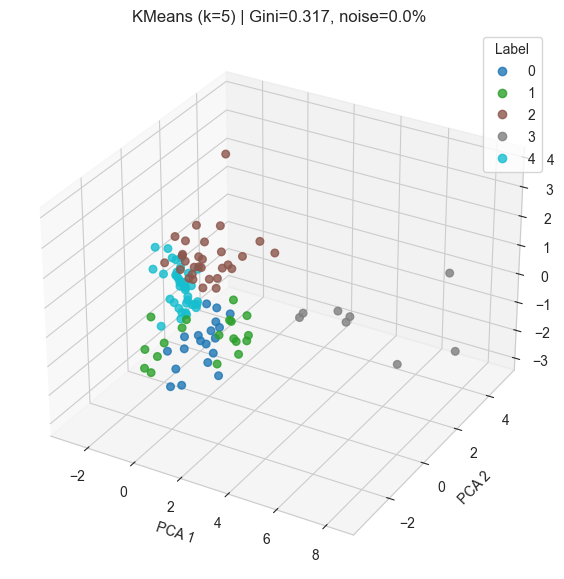

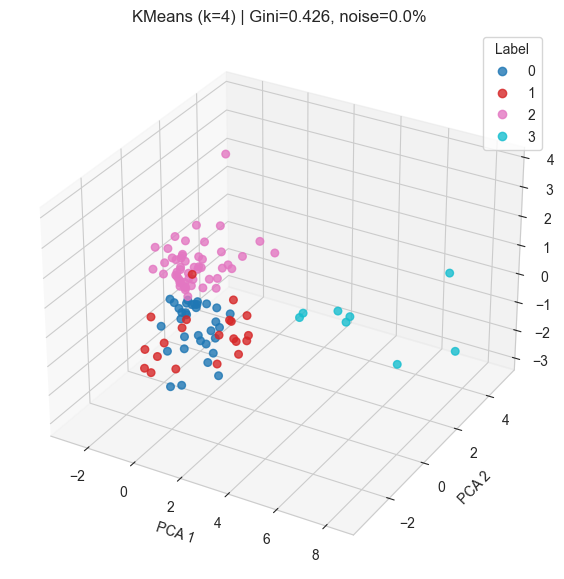

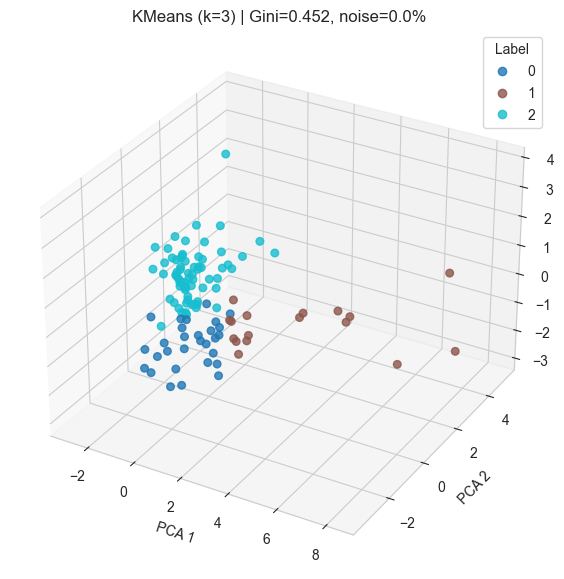

In [78]:
from sklearn.decomposition import PCA
# Visualize every filtered clustering result in 3D PCA space
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_coords = pca.fit_transform(X_scaled)

for idx, row in filtered_results.iterrows():
    model_name = row['model']
    if model_name == 'kmeans':
        clusterer = KMeans(n_clusters=int(row['clust. #']), random_state=42)
        title = f"KMeans (k={int(row['clust. #'])})"
    elif model_name == 'dbscan':
        eps = row.get('HP (eps)')
        min_samp = row.get('HP (min_samp)')
        if pd.isna(eps) or pd.isna(min_samp):
            continue
        clusterer = DBSCAN(eps=float(eps), min_samples=int(min_samp), n_jobs=-1)
        title = f"DBSCAN (eps={float(eps):.2f}, min_samp={int(min_samp)})"
    elif model_name == 'hdbscan':
        min_samp = row.get('HP (min_samp)')
        min_clust = row.get('HP (min_clust)')
        if pd.isna(min_samp):
            continue
        min_clust_int = int(min_clust) if pd.notna(min_clust) else None
        clusterer = hdbscan.HDBSCAN(min_samples=int(min_samp),
                                    min_cluster_size=min_clust_int)
        min_clust_desc = f", min_clust={int(min_clust)}" if pd.notna(min_clust) else ''
        title = f"HDBSCAN (min_samp={int(min_samp)}{min_clust_desc})"
    else:
        continue

    labels = clusterer.fit_predict(X_scaled)
    core_mask = labels != -1
    noise_mask = labels == -1

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    scatter = None
    if core_mask.any():
        scatter = ax.scatter(
            pca_coords[core_mask, 0],
            pca_coords[core_mask, 1],
            pca_coords[core_mask, 2],
            c=labels[core_mask],
            cmap='tab10',
            s=30,
            alpha=0.8
        )

    if noise_mask.any():
        ax.scatter(
            pca_coords[noise_mask, 0],
            pca_coords[noise_mask, 1],
            pca_coords[noise_mask, 2],
            c='lightgray',
            s=15,
            alpha=0.4
        )

    ax.set_title(f"{title} | Gini={row['Gini']:.3f}, noise={row['noise %']:.1f}%")
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.set_zlabel('PCA 3')

    legend_handles = []
    legend_labels = []

    if scatter is not None:
        handles, labels_list = scatter.legend_elements()
        legend_handles.extend(handles)
        legend_labels.extend(labels_list)

    if noise_mask.any():
        noise_proxy = ax.scatter([], [], [], c='lightgray', s=20, alpha=0.4)
        legend_handles.append(noise_proxy)
        legend_labels.append('Noise')

    if legend_handles:
        ax.legend(legend_handles, legend_labels, title='Label')

    plt.show()


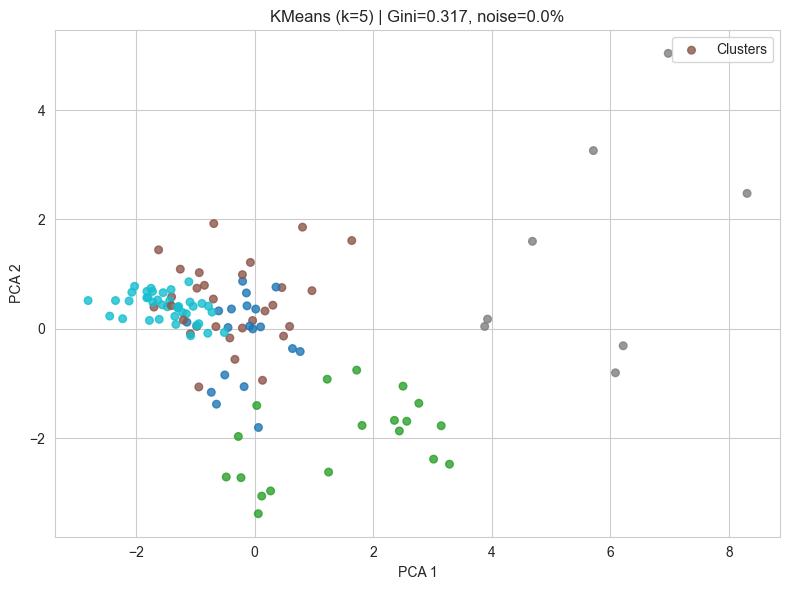

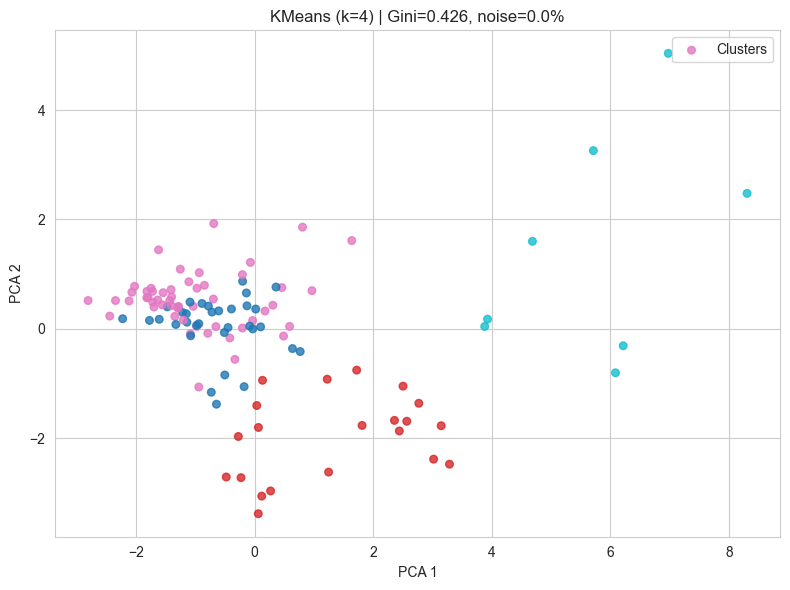

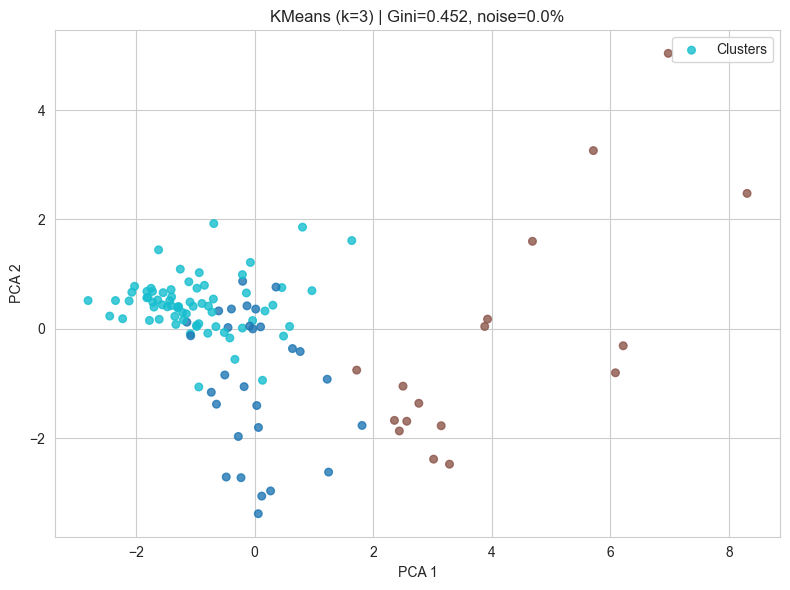

In [79]:
# Visualize filtered clustering results in 2D (PCA1 vs PCA2)
pca_2d = PCA(n_components=2)
pca_coords_2d = pca_2d.fit_transform(X_scaled)

for idx, row in filtered_results.iterrows():
    model_name = row['model']
    if model_name == 'kmeans':
        clusterer = KMeans(n_clusters=int(row['clust. #']), random_state=42)
        title = f"KMeans (k={int(row['clust. #'])})"
    elif model_name == 'dbscan':
        eps = row.get('HP (eps)')
        min_samp = row.get('HP (min_samp)')
        if pd.isna(eps) or pd.isna(min_samp):
            continue
        clusterer = DBSCAN(eps=float(eps), min_samples=int(min_samp), n_jobs=-1)
        title = f"DBSCAN (eps={float(eps):.2f}, min_samp={int(min_samp)})"
    elif model_name == 'hdbscan':
        min_samp = row.get('HP (min_samp)')
        min_clust = row.get('HP (min_clust)')
        if pd.isna(min_samp):
            continue
        min_clust_int = int(min_clust) if pd.notna(min_clust) else None
        clusterer = hdbscan.HDBSCAN(min_samples=int(min_samp),
                                    min_cluster_size=min_clust_int)
        min_clust_desc = f", min_clust={int(min_clust)}" if pd.notna(min_clust) else ''
        title = f"HDBSCAN (min_samp={int(min_samp)}{min_clust_desc})"
    else:
        continue

    labels = clusterer.fit_predict(X_scaled)
    core_mask = labels != -1
    noise_mask = labels == -1

    plt.figure(figsize=(8, 6))
    if core_mask.any():
        plt.scatter(
            pca_coords_2d[core_mask, 0],
            pca_coords_2d[core_mask, 1],
            c=labels[core_mask],
            cmap='tab10',
            s=30,
            alpha=0.8,
            label='Clusters'
        )

    if noise_mask.any():
        plt.scatter(
            pca_coords_2d[noise_mask, 0],
            pca_coords_2d[noise_mask, 1],
            c='lightgray',
            s=15,
            alpha=0.4,
            label='Noise'
        )

    plt.title(f"{title} | Gini={row['Gini']:.3f}, noise={row['noise %']:.1f}%")
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    if core_mask.any() or noise_mask.any():
        plt.legend()
    plt.tight_layout()
    plt.show()


In [80]:
# Cluster-level feature means for a selected result
if filtered_results.empty:
    raise ValueError('filtered_results is empty – rerun the modeling/filtering cells first.')

selected_result_position = 0  # 0-based position
selected_result_index = 1  # set to an explicit DataFrame index (e.g., 512) to select by label

if selected_result_index is not None:
    if selected_result_index not in filtered_results.index:
        raise IndexError(f'selected_result_index {selected_result_index} not found in filtered_results.index')
    selected_row = filtered_results.loc[selected_result_index]
else:
    if not 0 <= selected_result_position < len(filtered_results):
        raise IndexError(f'selected_result_position {selected_result_position} is out of bounds for size {len(filtered_results)}')
    selected_row = filtered_results.iloc[selected_result_position]

model_name = selected_row['model']
if model_name == 'kmeans':
    clusterer = KMeans(n_clusters=int(selected_row['clust. #']), random_state=42)
elif model_name == 'dbscan':
    eps = selected_row.get('HP (eps)')
    min_samp = selected_row.get('HP (min_samp)')
    if pd.isna(eps) or pd.isna(min_samp):
        raise ValueError('Selected DBSCAN row is missing eps/min_samp hyperparameters.')
    clusterer = DBSCAN(eps=float(eps), min_samples=int(min_samp), n_jobs=-1)
elif model_name == 'hdbscan':
    min_samp = selected_row.get('HP (min_samp)')
    min_clust = selected_row.get('HP (min_clust)')
    if pd.isna(min_samp):
        raise ValueError('Selected HDBSCAN row is missing min_samp.')
    min_clust_int = int(min_clust) if pd.notna(min_clust) else None
    clusterer = hdbscan.HDBSCAN(min_samples=int(min_samp),
                                min_cluster_size=min_clust_int)
else:
    raise ValueError(f'Unknown model {model_name}')

cluster_assignments = clusterer.fit_predict(X_scaled)
feature_level_df = df.copy()
feature_level_df['cluster'] = cluster_assignments
include_noise_cluster = False  # flip to True if you want cluster -1 retained
if not include_noise_cluster:
    feature_level_df = feature_level_df[feature_level_df['cluster'] != -1]

if feature_level_df.empty:
    raise ValueError('No samples left to summarize (all were labeled as noise).')

selected_row_index = selected_row.name
title = f"Cluster means for {model_name} (index={selected_row_index})"
cluster_means = feature_level_df.groupby('cluster').mean().sort_index()
cluster_counts = feature_level_df.groupby('cluster').size().rename('count')
cluster_summary = pd.concat([cluster_counts, cluster_means], axis=1)
cluster_summary = cluster_summary.T
cluster_summary.index.name = 'feature'
cluster_summary.columns.name = 'cluster'
print(f"{title} — features vs. clusters")
display(cluster_summary)


Cluster means for kmeans (index=1) — features vs. clusters


cluster,0,1,2
feature,,,
count,29.000000,17.000000,69.000000
eventDurationSeconds,4.816363,6.852669,4.351946
eventMilesDriven,0.011167,0.048616,0.011854
eventStartSpeed,9.024853,27.884212,11.252560
eventEndSpeed,12.678442,29.184148,15.152115
memsMedianHorizontalNorm,1.402433,1.513025,2.371265
gyro_angular_change_per_second,12.993026,7.787112,19.319616
gyroAngleChange,63.804544,52.163185,83.752604
mems_radius,16.692093,32.708380,8.786200


/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_4344/3257457420.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


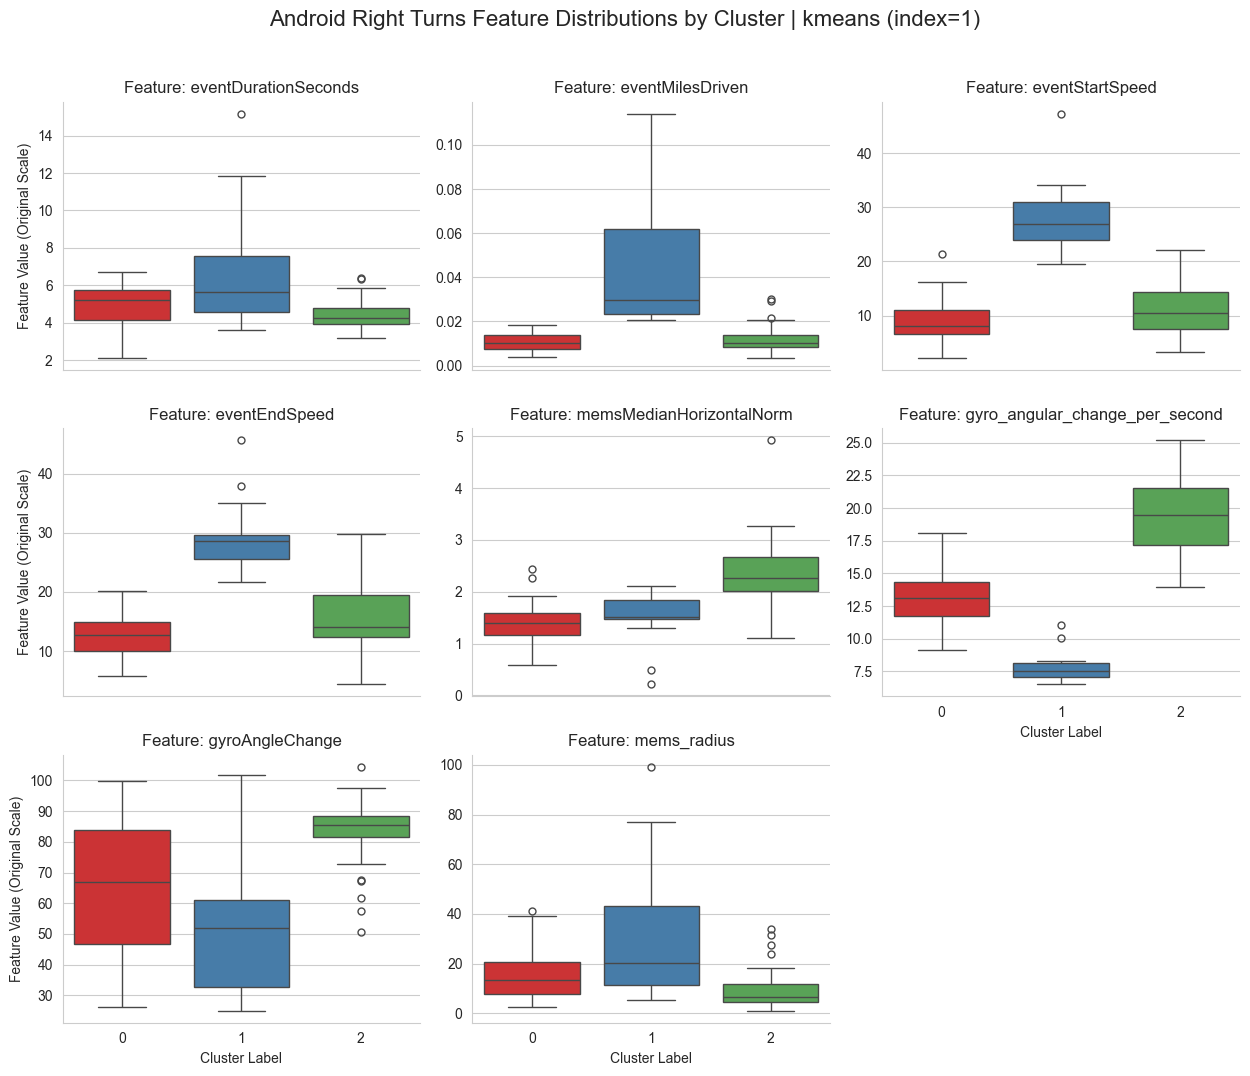

In [81]:
# Feature distributions by cluster for a selected filtered result
if filtered_results.empty:
    raise ValueError('filtered_results is empty – rerun the modeling/filtering cells first.')

plot_result_position = 0  # 0-based ordinal
plot_result_index = 1  # set to a concrete DataFrame index (e.g., 512) to select a specific row

if plot_result_index is not None:
    if plot_result_index not in filtered_results.index:
        raise IndexError(f'plot_result_index {plot_result_index} not found in filtered_results.index')
    selected_row = filtered_results.loc[plot_result_index]
else:
    if not 0 <= plot_result_position < len(filtered_results):
        raise IndexError(f'plot_result_position {plot_result_position} is out of bounds for size {len(filtered_results)}')
    selected_row = filtered_results.iloc[plot_result_position]

model_name = selected_row['model']
if model_name == 'kmeans':
    clusterer = KMeans(n_clusters=int(selected_row['clust. #']), random_state=42)
elif model_name == 'dbscan':
    eps = selected_row.get('HP (eps)')
    min_samp = selected_row.get('HP (min_samp)')
    if pd.isna(eps) or pd.isna(min_samp):
        raise ValueError('Selected DBSCAN row is missing eps/min_samp hyperparameters.')
    clusterer = DBSCAN(eps=float(eps), min_samples=int(min_samp), n_jobs=-1)
elif model_name == 'hdbscan':
    min_samp = selected_row.get('HP (min_samp)')
    min_clust = selected_row.get('HP (min_clust)')
    if pd.isna(min_samp):
        raise ValueError('Selected HDBSCAN row is missing min_samp.')
    min_clust_int = int(min_clust) if pd.notna(min_clust) else None
    clusterer = hdbscan.HDBSCAN(min_samples=int(min_samp), min_cluster_size=min_clust_int)
else:
    raise ValueError(f'Unknown model {model_name}')

cluster_assignments = clusterer.fit_predict(X_scaled)
df_clustered = df.copy()
df_clustered['Cluster_Label'] = cluster_assignments
include_noise_cluster = False  # flip to True if you want cluster -1 shown
if not include_noise_cluster:
    df_clustered = df_clustered[df_clustered['Cluster_Label'] != -1]

if df_clustered.empty:
    raise ValueError('No samples remain to visualize (all labeled as noise).')

df_clustered['Cluster_Label'] = df_clustered['Cluster_Label'].astype('category')
if 'features_to_plot' not in globals():
    features_to_plot = df.columns.tolist()

df_melted = df_clustered[['Cluster_Label'] + features_to_plot].melt(
    id_vars=['Cluster_Label'],
    var_name='Feature',
    value_name='Value'
)

sns.set_style('whitegrid')
g = sns.catplot(
    data=df_melted,
    x='Cluster_Label',
    y='Value',
    col='Feature',
    kind='box',
    col_wrap=3,
    palette='Set1',
    sharey=False,
    height=3.5,
    aspect=1.2
)

run_label = f"{model_name} (index={selected_row.name})"
g.fig.suptitle(f'Android Right Turns Feature Distributions by Cluster | {run_label}', y=1.02, fontsize=16)
g.set_titles('Feature: {col_name}', size=12)
g.set_axis_labels('Cluster Label', 'Feature Value (Original Scale)', size=10)
plt.tight_layout()
plt.show()
